In [1]:
%config IPCompleter.greedy=True
%pylab inline

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

Populating the interactive namespace from numpy and matplotlib


# Music Genre Classification - Random Forest training on CSV v1 file features

## Numerical and Graphical Descriptive analysis


In [2]:
dataset_file = "datasets/data-v1.csv"

df = pd.read_csv(dataset_file, sep=",")
df.describe()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.380795,0.124698,1883.001208,1865.303842,3878.803772,0.101184,-162.754063,121.255273,-29.199931,54.109434,...,-7.320438,3.900521,-2.205811,-2.243190,1.619559,-5.134632,3.043665,-6.634297,5.002622,-7.852236
std,0.082699,0.062342,522.242739,339.144108,1096.400581,0.039370,95.151859,23.111192,20.168244,16.110998,...,5.512331,5.395750,4.365042,3.977097,3.694564,3.984223,4.333503,4.096735,4.316616,4.287511
min,0.171805,0.005014,549.065530,796.514455,710.220705,0.021877,-556.024780,42.361320,-99.755829,-3.247742,...,-32.414146,-14.018186,-20.763159,-16.360909,-12.323302,-19.637094,-12.697938,-18.963448,-13.177314,-22.937521
25%,0.321059,0.082679,1461.113254,1643.098517,3034.883732,0.071043,-213.648769,104.958897,-42.612360,45.396466,...,-11.082822,0.603397,-5.172873,-4.874094,-0.737182,-7.606263,0.300295,-9.524103,2.242899,-10.705755
50%,0.385390,0.116670,1926.222388,1943.105990,4064.821254,0.097405,-138.674522,118.840340,-30.713336,54.597818,...,-7.538498,4.457320,-2.305679,-2.279468,1.757869,-5.469918,3.286095,-6.899161,5.105744,-8.184787
75%,0.439446,0.167502,2277.180673,2110.350537,4748.075456,0.128231,-95.242519,135.433762,-17.951447,64.680765,...,-3.929274,7.729157,0.444397,0.385467,4.065663,-2.710800,5.842021,-4.012571,8.109790,-5.197460
max,0.667248,0.378549,3369.517356,2611.325445,6268.003765,0.257681,15.127309,197.522858,55.721581,98.046173,...,11.871216,17.391365,13.880814,10.114944,17.297344,9.187266,22.280184,11.137421,22.338120,10.675509


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:357: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds,


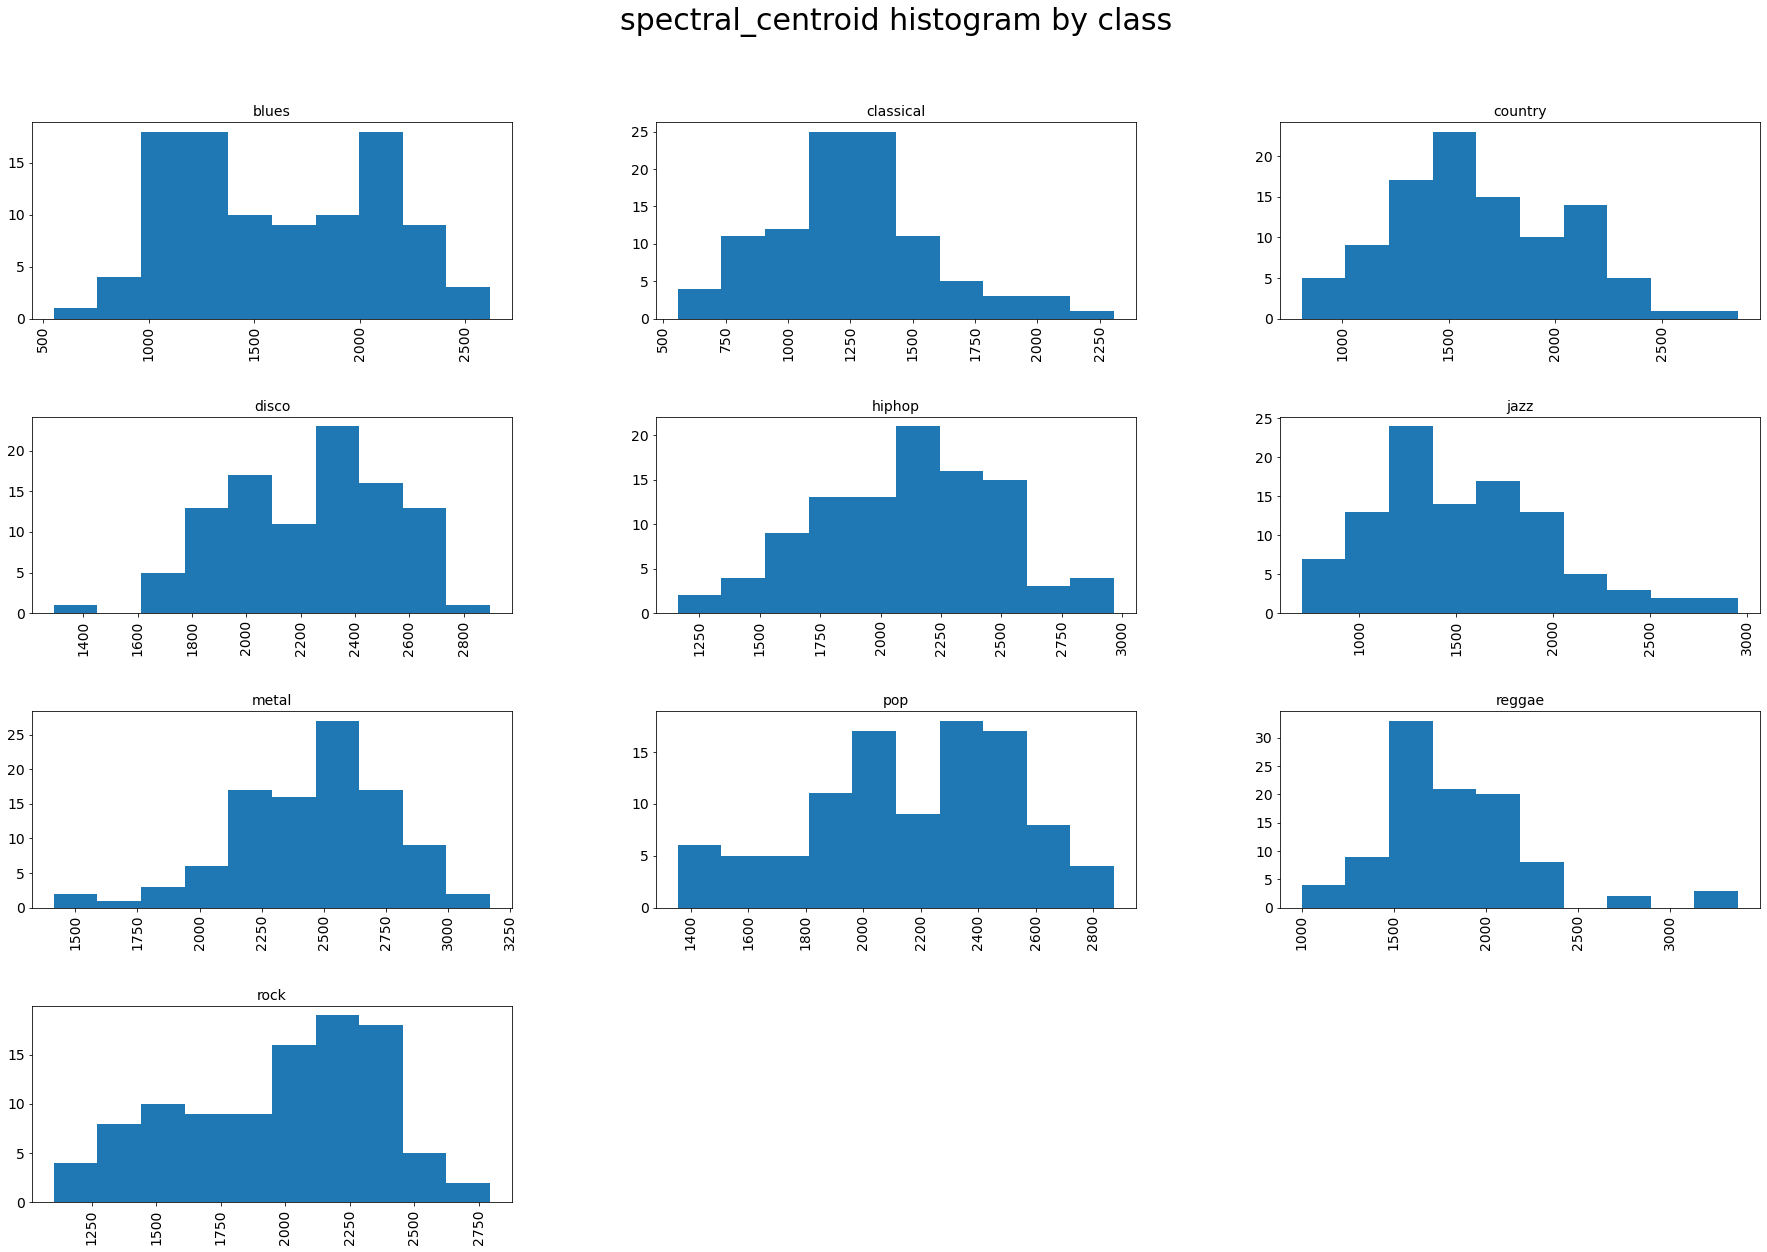

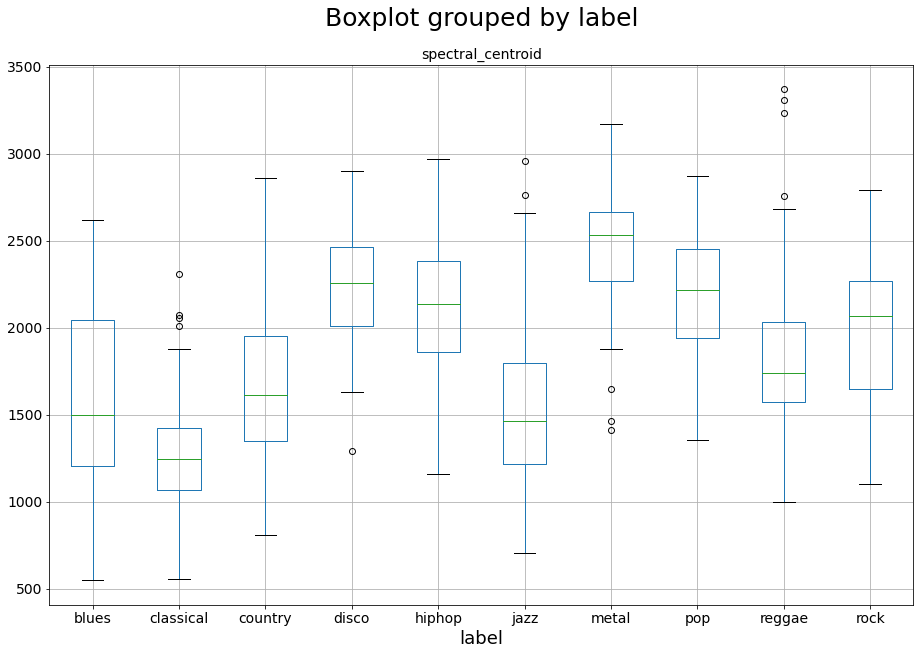

In [39]:
from sklearn import preprocessing

X = df.drop(["label", "filename"], axis=1).values

std_scale = preprocessing.StandardScaler().fit(X) # applying feature scaling because PCA uses euclidean distance to ocompute clusters

X = std_scale.transform(X)

y = df["label"].values

In [20]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

encoder = preprocessing.LabelEncoder()
encoder.fit(y)

y_encoded = encoder.transform(y)

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y_encoded)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

In [24]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 50, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 30, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


rf = RandomForestClassifier()


# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42)

rf_random.fit(X_train_full, y_train_full)

rf_random.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=6, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=6, bootstrap=True, total=   0.0s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=6, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=6, bootstrap=True, total=   0.0s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=6, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=6, bootstrap=True, total=   0.0s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=6, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=6, bootstrap=True, tot

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=1, bootstrap=True, total=   0.1s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=1, bootstrap=True 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=1, bootstrap=True, total=   0.1s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=1, bootstrap=True 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=1, bootstrap=True, total=   0.1s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=1, bootstrap=True 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=1, bootstrap=True, total=   0.1s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=1, bootstrap=True 
[CV]  n_estimators=50, min_samples_split=5, min_samp

[CV]  n_estimators=25, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=False, total=   0.1s
[CV] n_estimators=25, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=False 
[CV]  n_estimators=25, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=False, total=   0.1s
[CV] n_estimators=25, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=False 
[CV]  n_estimators=25, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=False, total=   0.1s
[CV] n_estimators=25, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=False 
[CV]  n_estimators=25, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=False, total=   0.1s
[CV] n_estimators=25, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=False 
[CV]  n_estimators=25, min_samples_s

[CV]  n_estimators=45, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=12, bootstrap=False, total=   0.2s
[CV] n_estimators=45, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=12, bootstrap=False 
[CV]  n_estimators=45, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=12, bootstrap=False, total=   0.2s
[CV] n_estimators=45, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=12, bootstrap=False 
[CV]  n_estimators=45, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=12, bootstrap=False, total=   0.2s
[CV] n_estimators=45, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=12, bootstrap=False 
[CV]  n_estimators=45, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=12, bootstrap=False, total=   0.1s
[CV] n_estimators=45, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=12, bootstrap=False 
[CV]  n_estimators=45, min_samples_s

[CV]  n_estimators=35, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=21, bootstrap=True, total=   0.1s
[CV] n_estimators=35, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=21, bootstrap=True 
[CV]  n_estimators=35, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=21, bootstrap=True, total=   0.1s
[CV] n_estimators=35, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=21, bootstrap=True 
[CV]  n_estimators=35, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=21, bootstrap=True, total=   0.1s
[CV] n_estimators=45, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=45, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, total=   0.1s
[CV] n_estimators=45, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=45, min_samples_spl

[CV]  n_estimators=30, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=3, bootstrap=True, total=   0.1s
[CV] n_estimators=30, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=3, bootstrap=True 
[CV]  n_estimators=30, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=3, bootstrap=True, total=   0.1s
[CV] n_estimators=30, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=False 
[CV]  n_estimators=30, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=False, total=   0.1s
[CV] n_estimators=30, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=False 
[CV]  n_estimators=30, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=False, total=   0.1s
[CV] n_estimators=30, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=False 
[CV]  n_estimators=30, min_samples_split=1

[CV]  n_estimators=30, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=3, bootstrap=True, total=   0.1s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=27, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=27, bootstrap=True, total=   0.1s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=27, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=27, bootstrap=True, total=   0.1s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=27, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=27, bootstrap=True, total=   0.1s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=27, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=2, m

[CV]  n_estimators=25, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   0.1s
[CV] n_estimators=25, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  n_estimators=25, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   0.1s
[CV] n_estimators=25, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  n_estimators=25, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   0.1s
[CV] n_estimators=25, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  n_estimators=25, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   0.1s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=24, bootstrap=True 
[CV]  n_estimators=50, min_samples_split=2, 

[CV]  n_estimators=25, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=12, bootstrap=False, total=   0.1s
[CV] n_estimators=25, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=12, bootstrap=False 
[CV]  n_estimators=25, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=12, bootstrap=False, total=   0.1s
[CV] n_estimators=25, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=6, bootstrap=False 
[CV]  n_estimators=25, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=6, bootstrap=False, total=   0.1s
[CV] n_estimators=25, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=6, bootstrap=False 
[CV]  n_estimators=25, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=6, bootstrap=False, total=   0.1s
[CV] n_estimators=25, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=6, bootstrap=False 
[CV]  n_estimators=25, min_samples_spl

[CV]  n_estimators=35, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=21, bootstrap=True, total=   0.1s
[CV] n_estimators=5, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=12, bootstrap=True 
[CV]  n_estimators=5, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=12, bootstrap=True, total=   0.0s
[CV] n_estimators=5, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=12, bootstrap=True 
[CV]  n_estimators=5, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=12, bootstrap=True, total=   0.0s
[CV] n_estimators=5, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=12, bootstrap=True 
[CV]  n_estimators=5, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=12, bootstrap=True, total=   0.0s
[CV] n_estimators=5, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=12, bootstrap=True 
[CV]  n_estimators=5, min_samples_split=2, min_sam

[CV]  n_estimators=45, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=1, bootstrap=False, total=   0.1s
[CV] n_estimators=45, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=1, bootstrap=False 
[CV]  n_estimators=45, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=1, bootstrap=False, total=   0.1s
[CV] n_estimators=35, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=18, bootstrap=True 
[CV]  n_estimators=35, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=18, bootstrap=True, total=   0.1s
[CV] n_estimators=35, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=18, bootstrap=True 
[CV]  n_estimators=35, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=18, bootstrap=True, total=   0.1s
[CV] n_estimators=35, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=18, bootstrap=True 
[CV]  n_estimators=35, min_samples_split=2, 

[CV]  n_estimators=40, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=24, bootstrap=True, total=   0.1s
[CV] n_estimators=40, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=24, bootstrap=True 
[CV]  n_estimators=40, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=24, bootstrap=True, total=   0.1s
[CV] n_estimators=40, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=24, bootstrap=True 
[CV]  n_estimators=40, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=24, bootstrap=True, total=   0.1s
[CV] n_estimators=40, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=24, bootstrap=True 
[CV]  n_estimators=40, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=24, bootstrap=True, total=   0.1s
[CV] n_estimators=40, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=24, bootstrap=True 
[CV]  n_estimators=40, min_samples_split=5, 

[CV]  n_estimators=15, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=27, bootstrap=True, total=   0.0s
[CV] n_estimators=25, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=27, bootstrap=True 
[CV]  n_estimators=25, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=27, bootstrap=True, total=   0.1s
[CV] n_estimators=25, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=27, bootstrap=True 
[CV]  n_estimators=25, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=27, bootstrap=True, total=   0.1s
[CV] n_estimators=25, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=27, bootstrap=True 
[CV]  n_estimators=25, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=27, bootstrap=True, total=   0.1s
[CV] n_estimators=25, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=27, bootstrap=True 
[CV]  n_estimators=25, min_samples_split=5,

[CV]  n_estimators=25, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=1, bootstrap=True, total=   0.0s
[CV] n_estimators=25, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=1, bootstrap=True 
[CV]  n_estimators=25, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=1, bootstrap=True, total=   0.0s
[CV] n_estimators=25, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=1, bootstrap=True 
[CV]  n_estimators=25, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=1, bootstrap=True, total=   0.0s
[CV] n_estimators=25, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=1, bootstrap=True 
[CV]  n_estimators=25, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=1, bootstrap=True, total=   0.0s
[CV] n_estimators=25, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=1, bootstrap=True 
[CV]  n_estimators=25, min_samples_split=10,

[CV]  n_estimators=5, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=27, bootstrap=False, total=   0.0s
[CV] n_estimators=5, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=27, bootstrap=False 
[CV]  n_estimators=5, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=27, bootstrap=False, total=   0.0s
[CV] n_estimators=5, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=27, bootstrap=False 
[CV]  n_estimators=5, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=27, bootstrap=False, total=   0.0s
[CV] n_estimators=5, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=27, bootstrap=False 
[CV]  n_estimators=5, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=27, bootstrap=False, total=   0.0s
[CV] n_estimators=5, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=27, bootstrap=False 
[CV]  n_estimators=5, min_samples_split=5, m

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   40.5s finished


{'n_estimators': 40,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 18,
 'bootstrap': False}

In [25]:
from sklearn.metrics import accuracy_score

best_random = rf_random.best_estimator_

y_pred = best_random.predict(X_test)

accuracy_score(y_test, y_pred)

0.628

Class 0: blues
Class 1: classical
Class 2: country
Class 3: disco
Class 4: hiphop
Class 5: jazz
Class 6: metal
Class 7: pop
Class 8: reggae
Class 9: rock


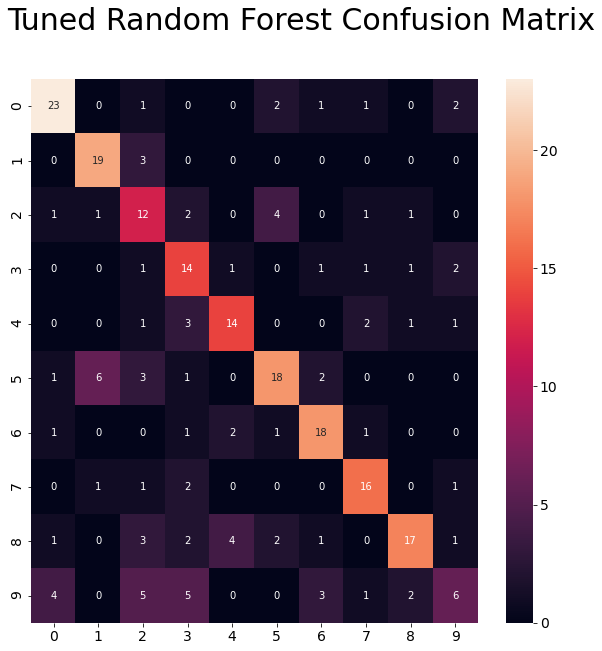

In [26]:
from sklearn.metrics import plot_confusion_matrix


y_pred_rf = best_random.predict(X_test)

show_confusion_matrix(y_test, y_pred_rf, encoder, "Tuned Random Forest Confusion Matrix")